In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [8]:
with open('../../data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
    idx_val = pickle.load(handle)
len(idx_val)

1000

In [9]:
import pandas as pd
df = pd.read_csv('../../../../codes/celeba/data/celeba/list_eval_partition.txt', delimiter=" ", 
                 names=['path', 'split'],
                 header=None, skipinitialspace=True)
df['path'] = df.apply(lambda x: "../../../../codes/celeba/data/celeba/img_align_celeba/{}".format(x['path']), axis=1)
df.head()    

,path,split
0,../../../../codes/celeba/data/celeba/img_align...,0
1,../../../../codes/celeba/data/celeba/img_align...,0
2,../../../../codes/celeba/data/celeba/img_align...,0
3,../../../../codes/celeba/data/celeba/img_align...,0
4,../../../../codes/celeba/data/celeba/img_align...,0


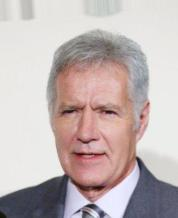

In [10]:
from datasets import Dataset, load_dataset, Image

train_dataset = Dataset.from_dict({"img": df.loc[idx_train]['path'].tolist(),
                                  }).cast_column("img", Image())
train_dataset[0]["img"]

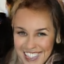

In [11]:
import pandas as pd
df = pd.DataFrame()
df['path'] = ['{}/{}.png'.format('../../saved/5000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": df['path'].tolist(),
}).cast_column("img", Image()),})
val_dataset = dataset["train"]
val_dataset[0]["img"]

In [12]:
class Args():
    resolution=64
    center_crop=True
    random_flip=False
args=Args()

In [13]:
from torchvision import transforms

if True:
    augmentations = transforms.Compose(
        [
            ####
            transforms.CenterCrop(140),
            ####
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )
    def transform_images(examples):
        # images = [augmentations(image.convert("RGB")) for image in examples["image"]]
        images = [augmentations(image.convert("RGB")) for image in examples["img"]]
        return {"input": images}
    
    train_dataset.set_transform(transform_images)
    
    val_dataset.set_transform(transform_images)

In [14]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu117


In [15]:
train_features = torch.stack([train_dataset[i]['input'] for i in range(5000)]).reshape(-1, 3*64*64)
val_features = torch.stack([val_dataset[i]['input'] for i in range(1000)]).reshape(-1, 3*64*64)

In [16]:
train_features_array = train_features.numpy()
val_features_array = val_features.numpy()

In [17]:
train_features_array.shape

(5000, 12288)

In [18]:
val_features_array.shape

(1000, 12288)

In [19]:
scores_list = []

In [20]:
scores = val_features_array.dot(train_features_array.T)
scores_list.append(scores)

In [21]:
scores = (val_features_array/np.linalg.norm(val_features_array, axis=1).reshape(-1, 1)).dot(
    (train_features_array/np.linalg.norm(train_features_array, axis=1).reshape(-1, 1)).T
)
scores_list.append(scores)

In [22]:
with open('./gen_clip.pkl', 'wb') as handle:
    pickle.dump(scores_list, handle)

In [23]:
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [24]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-gen.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

In [25]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [26]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

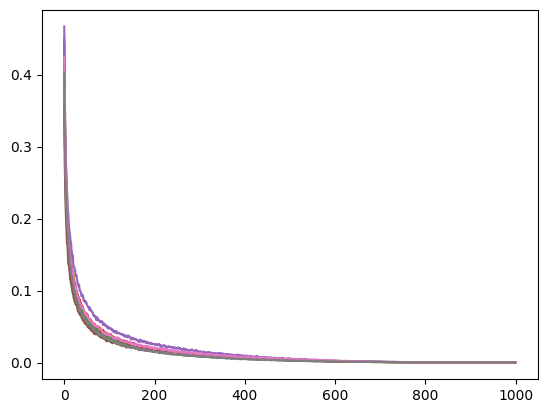

In [27]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [28]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
infl_est_ = -scores_list[0]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: -0.050 (avg p value 0.447640)


In [29]:
my_data = {
    'margins': margins[:, 0],
    'preds': preds[:, 0]
}

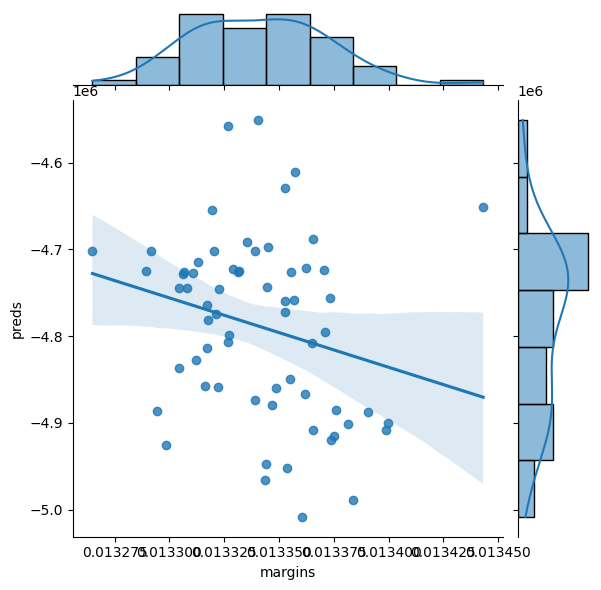

In [30]:
import seaborn as sns
sns.jointplot(data=my_data, x="margins", y="preds", kind="reg")

In [31]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
infl_est_ = -scores_list[1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: -0.045 (avg p value 0.450826)


In [32]:
my_data = {
    'margins': margins[:, 0],
    'preds': preds[:, 0]
}

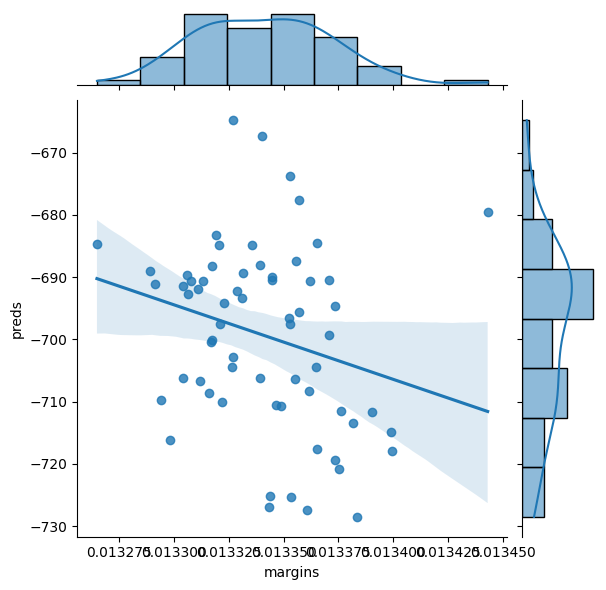

In [33]:
import seaborn as sns
sns.jointplot(data=my_data, x="margins", y="preds", kind="reg")

In [34]:
scores = scores_list[1]

In [35]:
i = 0

In [36]:
D = -scores[i]
D.shape

(5000,)

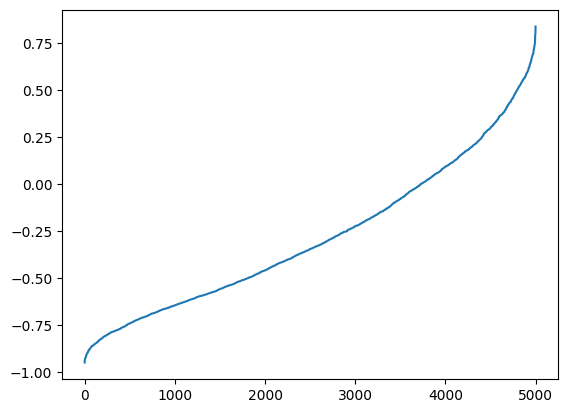

In [37]:
plt.plot(sorted(D))
# plt.axhline(y=0, c='red')